<a href="https://colab.research.google.com/github/akhil-gun/DSI_M3_NLP/blob/dev_mekondjo/Sarcasm_detection_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-text

In [ ]:
import io
import json
import pandas as pd 
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_json('/content/drive/MyDrive/Module_3/Sarcasm_Headlines_Dataset_v2.json', lines = True)

In [ ]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
df = df.drop('article_link', axis = 1)

In [ ]:
df["label_name"] = df["is_sarcastic"].apply(lambda x: 'sarcastic' if x == 1 else 'not_sarcastic')

In [ ]:
df.head()

,is_sarcastic,headline,label_name
0,1,thirtysomething scientists unveil doomsday clo...,sarcastic
1,0,dem rep. totally nails why congress is falling...,not_sarcastic
2,0,eat your veggies: 9 deliciously different recipes,not_sarcastic
3,1,inclement weather prevents liar from getting t...,sarcastic
4,1,mother comes pretty close to using word 'strea...,sarcastic


In [ ]:
df.shape

(28619, 3)

In [ ]:
df.isnull().sum()

is_sarcastic    0
headline        0
label_name      0
dtype: int64

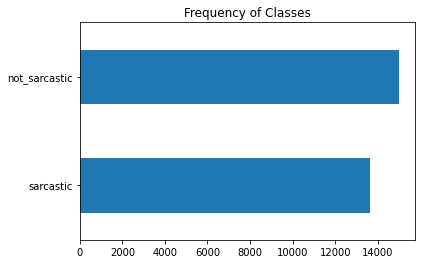

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


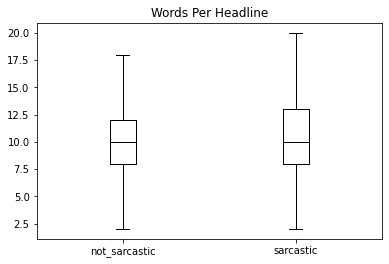

In [ ]:
df["Words Per Headline"] = df["headline"].str.split().apply(len)
df.boxplot("Words Per Headline", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
def preprocess(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    a_lemmas = [lemma.lower() for lemma in lemmas if lemma.isalpha() and lemma not in stopwords.words('english')]
    lemmatized_text = ' '.join(a_lemmas)
    return lemmatized_text

In [ ]:
def print_metrices(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [ ]:
cleaned_text = []
for text in df.headline:
    cleaned_text.append(preprocess(text))
df['clean_text'] = cleaned_text

In [ ]:
df.head()

,is_sarcastic,headline,label_name,Words Per Headline,clean_text
0,1,thirtysomething scientists unveil doomsday clo...,sarcastic,8,thirtysomething scientist unveil doomsday cloc...
1,0,dem rep. totally nails why congress is falling...,not_sarcastic,13,dem rep totally nail congress fall short gende...
2,0,eat your veggies: 9 deliciously different recipes,not_sarcastic,7,eat veggie deliciously different recipe
3,1,inclement weather prevents liar from getting t...,sarcastic,8,inclement weather prevent liar get work
4,1,mother comes pretty close to using word 'strea...,sarcastic,9,mother come pretty close use word streaming co...


In [ ]:
from wordcloud import WordCloud

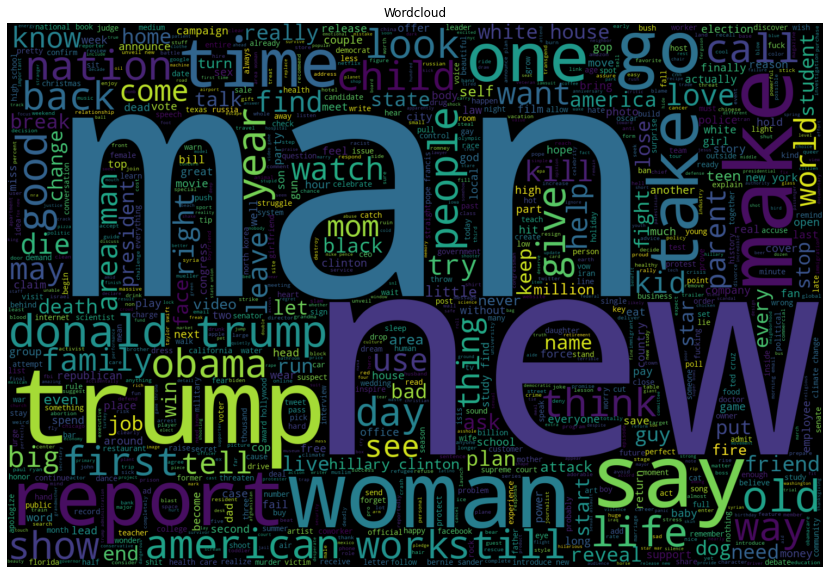

In [ ]:
plt.figure(figsize = (20,10))
wc = WordCloud(width = 1500,height = 1000,max_words = 1000).generate(' '.join(word for word in df.clean_text))
plt.axis("off")
plt.title('Wordcloud')
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

In [ ]:
#split into features and label
X = df['headline']
y = df['is_sarcastic']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify = df['is_sarcastic'],random_state = 42)

In [ ]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [ ]:
def get_sentence_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder (preprocessed_text)['pooled_output']

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
716/716 [==============================] - 95s 124ms/step - loss: 0.5979 - precision_2: 0.6932 - recall_2: 0.5975 - accuracy: 0.6823
Epoch 2/10
716/716 [==============================] - 88s 123ms/step - loss: 0.5234 - precision_2: 0.7609 - recall_2: 0.7021 - accuracy: 0.7530
Epoch 3/10
716/716 [==============================] - 88s 123ms/step - loss: 0.5055 - precision_2: 0.7612 - recall_2: 0.7260 - accuracy: 0.7610
Epoch 4/10
716/716 [==============================] - 88s 123ms/step - loss: 0.4916 - precision_2: 0.7698 - recall_2: 0.7317 - accuracy: 0.7680
Epoch 5/10
716/716 [==============================] - 88s 123ms/step - loss: 0.4861 - precision_2: 0.7749 - recall_2: 0.7398 - accuracy: 0.7737
Epoch 6/10
716/716 [==============================] - 87s 122ms/step - loss: 0.4789 - precision_2: 0.7721 - recall_2: 0.7466 - accuracy: 0.7743
Epoch 7/10
716/716 [==============================] - 87s 122ms/step - loss: 0.4754 - precision_2: 0.7754 - recall_2: 0.7484 - accuracy:

In [ ]:
model.evaluate(X_test, y_test)

179/179 [==============================] - 23s 122ms/step - loss: 0.4499 - precision_2: 0.8350 - recall_2: 0.7147 - accuracy: 0.7968


[0.4499230980873108,
 0.8350471258163452,
 0.7147048115730286,
 0.7968204021453857]

In [ ]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://131c019d-963b-476b-b532-774b8f7e557e/assets


INFO:tensorflow:Assets written to: ram://131c019d-963b-476b-b532-774b8f7e557e/assets
